In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rome-weather-classification/Rome Weather/Sunny/download (9).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (2).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (4).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/download (3).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (13).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (39).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/download (8).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (9).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (22).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (5).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (19).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (10).jpg
/kaggle/input/rome-weather-classification/Rome Weather/Sunny/images (23).jpg


In [4]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [18]:
splitfolders.ratio('../input/rome-weather-classification/Rome Weather', output="output", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)


Copying files: 0 files [00:00, ? files/s]
Copying files: 51 files [00:00, 409.70 files/s]
Copying files: 117 files [00:00, 543.13 files/s]
Copying files: 250 files [00:00, 615.28 files/s]


In [22]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [25]:
IMAGE_SIZE = [224, 224]

train_path = './train'
valid_path = './val'

In [26]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [27]:
folders = glob('./train/*')
folders

['./train/Foggy',
 './train/Sunny',
 './train/Cloudy',
 './train/Rainy',
 './train/Snowy']

In [28]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [29]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 185 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


In [33]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-07-08 06:02:23.185393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
6/6 [==============================] - 65s 10s/step - loss: 2.2703 - accuracy: 0.2757
Epoch 2/5
6/6 [==============================] - 60s 10s/step - loss: 1.2765 - accuracy: 0.4811
Epoch 3/5
6/6 [==============================] - 60s 10s/step - loss: 0.5832 - accuracy: 0.7838
Epoch 4/5
6/6 [==============================] - 59s 10s/step - loss: 0.4885 - accuracy: 0.8216
Epoch 5/5
6/6 [==============================] - 60s 10s/step - loss: 0.3593 - accuracy: 0.8865


KeyError: 'val_accuracy'

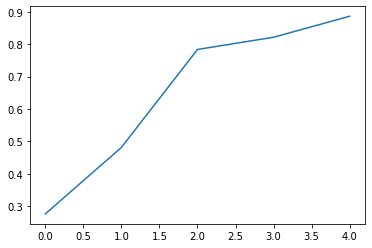

In [36]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')